# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Packages installation and imports

In [17]:
!pip install contractions
!pip install umap-learn
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install bitsandbytes
!pip install spacy
!python -m spacy download en
!python -m spacy download es

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 27.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the

In [18]:
#Imports
import pandas as pd
from tqdm import tqdm
from statistics import multimode
import re
import html
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
import contractions
import gensim
import gensim.downloader as gloader
from collections import OrderedDict
import numpy as np
import umap
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
import spacy
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

### Loading the Dataset

In [19]:
def load_data(split, path="/kaggle/input/a1-data"): 
    """
    Function to load the dataset, expects to find json files
    >split: portion of the dataset to load
    >path:  path to the directory containing the data
    """
    df = pd.read_json(f"{path}/{split}.json").T
    return df.set_index("id_EXIST")

In [20]:
#Loading data in three different splits: training, validation and test
training = load_data("training")
validation = load_data("validation")
test = load_data("test")

#Displaying the initial rows of the training split
display(training.head())

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


### Computing labels

In [21]:
def create_hl1(df):
    """
    Function to create the labels according to the instructions given: starting from label_task1 assign majority when present, drop if not,
    the new label is inserted in a new column 'hard_label_task1', the assignment is performed using the multimode function, which returns a list
    of the most frequent items, if the list has length 1, there is a clear majority.
    >df: dataframe containing the loaded split
    """
    df['hard_label_task1']=None
    for index, row in tqdm(df.iterrows()):
        vote = multimode(row['labels_task1'])
        if len(vote)==1:
            df.loc[index, 'hard_label_task1']=vote[0]
        else:
            df.drop([index], inplace=True)

In [22]:
#Processing train, validation and test to create the hard labels
create_hl1(training)
create_hl1(validation)
create_hl1(test)

#Displaying the initial rows of the training split to show the change
training.head()

6920it [00:04, 1425.66it/s]
726it [00:00, 3249.68it/s]
312it [00:00, 5159.80it/s]


,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
id_EXIST,,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,YES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,NO
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,NO
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,YES
100006,es,@yonkykong Aaah sí. Andrew Dobson. El que se d...,6,"[Annotator_25, Annotator_26, Annotator_27, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,NO


### Column removal and label encoding

In [23]:
def remove_cols(df, lang='en'):
    """
    Function to remove the undesired columns and rows from the dataframe
    >df:    dataframe to remove columns from
    >lang:  task language, 'en' to keep all english tweets, 'es' to keep all spanish tweets
    """
    keep_cols = ["lang", "tweet", "hard_label_task1"]
    lang_filter = df["lang"]==lang
    return df.loc[lang_filter, keep_cols]

def hot_enc(df):
    """
    Function to perform One Hot Encoding on hard_label_task1 converting YES to 1 and NO to 0
    >df: dataframe on which the action will be performed
    """
    df['hard_label_task1']=df['hard_label_task1'].replace({'YES':1, 'NO':0}).astype(int)
    return df

In [24]:
#Performing row and columns selection and one hot encoding according to instructions
training = remove_cols(training, 'en')
training = hot_enc(training)
validation = remove_cols(validation, 'en')
validation = hot_enc(validation)
test = remove_cols(test, 'en')
test = hot_enc(test)

#Displaying the initial rows of the training split to show the change
training.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
200002,en,Writing a uni essay in my local pub with a cof...,1
200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,en,According to a customer I have plenty of time ...,1
200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.


### Definition of cleaning functions

In [25]:
def remove_emoji(tweet):
    """
    Function to remove all emoji characters from the input text
    >tweet: text from which the emojis will be removed
    """
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                      "]+", re.UNICODE)
    tweet=emoji.sub(r'', tweet)
    return tweet.strip()

def remove_urls(tweet):
    """
    Function to remove all URLs from the input text
    >tweet: text from which the URLs will be removed
    """
    tweet = re.sub(r"(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))))+(?:(([^\s()<>]+|(([^\s()<>]+))))|[^\s`!()[]{};:\'\".,<>?«»“”‘’]))", ' ' ,tweet)
    return tweet.strip()

def remove_hashtags(tweet):
    """
    Function to remove all 'hashtags' from the input text, meaning sequences in the form '#sample'
    >tweet: text from which the hashtags will be removed
    """
    #tweet = tweet.replace('#', ' ')
    tweet = re.sub(r"(#+[a-zA-Z0-9(_)]{1,})", ' ',tweet)
    return tweet.strip()

def remove_mentions(tweet):
    """
    Function to remove all username mentions from the input text, meaning sequences in the form '@username'
    >tweet: text from which the mentions will be removed
    """
    tweet = re.sub(r"(@+[a-zA-Z0-9(_)]{1,})", ' ',tweet)
    return tweet.strip()

def remove_special(tweet):
    """
    Function to remove all other special combinations of characters from the input text, starting from alphanumeric combinations (1st, 2nd,...)
    and proceeding with purely non-letter symbols (punctuation, quotes, ...)
    >tweet: text from which the special characters will be removed
    """
    tweet = re.sub(r"\S*\d\S*", ' ',tweet)
    tweet = re.sub(r"[^a-zA-Z]", ' ',tweet)
    return tweet.strip()

def remove_whitespace(text):
    """
    Function that reformats the input text so that every couple of words is separated only by one white space character
    >tweet: text to be reformatted
    """
    return  " ".join(text.split())

def remove_accents(tweet):
    """
    This function replaces all accented characters in the input text with their base counterparts (mostly used for Spanish tweets)
    >tweet: text from which accented words will be replaced
    """
    accents = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n', 'ü':'u'}
    for a in accents.keys():
        tweet=tweet.replace(a,accents[a])
    return tweet.strip()

def clean_all(text, lang='en'):
    """
    This function performs every reduction function described before on the input text, distingushing between English and Spanish
    preprocessing strategies.
    >text: text to be cleaned
    >lang: language for the preprocessing
    """
    text=text.lower()
    text = html.unescape(text)
    if lang == 'en':
        functions = [remove_emoji, remove_urls, remove_hashtags, remove_mentions, remove_special, remove_whitespace]
    else:
        functions = [remove_emoji, remove_urls, remove_hashtags, remove_mentions, remove_accents, remove_special, remove_whitespace] #Accents are removed in Spanish tweets
    for func in functions:
        text = func(text)
    return text

### Lemmatization functions

To perform lemmatization we used the spacy library, in order to be able to process tweets both in English and Spanish using the same API.

In [26]:
#Loading lemmatization model
eng_model = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [27]:
def lem_text(text, lang='en'):
    """
    Function to perform lemmatization on the input text depending on the specified language: either English or Spanish
    >text: text to lemmatize
    >lang: language to consider when performing the lemmatization
    """
    if lang == 'en':
        tokens = eng_model(text)
    else:
        tokens = esp_model(text)
    words = [token.lemma_ for token in tokens]
    return    " ".join(words)

def remove_stop_words(text, lang='en'):
    """
    Function to remove the stopwords from the preprocessed text
    """
    if lang == 'en':
        tokens = eng_model(text)
    else:
        tokens = esp_model(text)
    words = [token.text for token in tokens if not token.is_stop]
    return    " ".join(words)

### Complete cleaning

In [28]:
def clean_dataframe(df,stop=True, contr=True, lang='en'):
    """
    Function to perform complete cleaning on every tweet in the dataframe: if specified it can remove contractions (useful for English),
    then removes every special character, then performs lemmatization, finally, if specified, it removes every stopword from the text (such as: a, the,... )
    >df: dataframe to process
    >stop: boolean, whether or not to remove stopwords
    >contr: boolean, whether or not to resolve contractions
    >lang: languge in which the preprocessing must be carried out
    """
    for index, row in tqdm(df.iterrows()):
        new_text = df['tweet'][index]
        if contr and lang=='en':
            new_text = contractions.fix(new_text)
        new_text=clean_all(new_text, lang)
        new_text=lem_text(new_text, lang)
        if stop:
            new_text = remove_stop_words(new_text)

        df.at[index, 'tweet']=new_text.strip()
    return df

In [29]:
#Performing the full cleaning process on the dataframe keeping stopwords and resolving contractions
training=clean_dataframe(training, False, True, 'en')
validation=clean_dataframe(validation, False, True, 'en')
test=clean_dataframe(test, False, True, 'en')

#Visualize the first columns of the dataframe train split to inspect the result
training.head()

2870it [00:24, 117.69it/s]
158it [00:01, 123.38it/s]
286it [00:02, 122.64it/s]


,lang,tweet,hard_label_task1
id_EXIST,,,
200002,en,write a uni essay in my local pub with a coffe...,1
200003,en,it be not I do not appreciate that on two ride...,1
200006,en,accord to a customer I have plenty of time to ...,1
200007,en,so only bloke drink beer sorry but if you be n...,1
200008,en,new to the shelf this week look forward to rea...,0


### Alternative Preprocessing Strategies

In an attempt to find the best pipeline to process all of the tweets we tried to apply some of the most common alternative preprocessing strategies associated with tweet processing, keeping only those which lead to a significative improvement:

*   Remove stopwords; initially assuming that stopwords weren't useful as they did not carry an inherent sentiment we experimented with their removal. The results, however, where worse than before and this could be related to their contribution to the context as some of them (e.g. 'not'), play an important role in determining the sentiment of other words
*   Resolve contractions; as a language, English, especially in informal texts, uses contractions, we decided to leverage this by resolving them, thus avoiding the creation of non existing words as a result of the removal of the apostrophe
*   Keeping digits; despite removal of digits and numbers being pretty common as a preprocessing step, we experimented by keeping them assuming they might have given some form of additional information. The following results provided thas this was not the case.
*   Keeping hashtag words; tweets commonly contain moltitudes of hashtags, some of which are substituting entire meaningful words (e.g. 'I #love #chocolate') so we decided to experiment by removing only the hashtag symbol itself to try and validate this theory. Unfortunately, results were worsened, probably because of their unclear syntax which resulted in the creation of new OOVs. 

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

### Downloading the embedding

The GloVe embedding offers many different configuations built from various knowledge bases the most prominent are those derived from Wikipedia and Twitter, each one available in different embedding dimensions. After some evaluation we opted for the twitter-based embedding with dimension 200 as it lead to slightly better results and felt like a more natural choice considering the task assigned.

In [30]:
#Download of the embedding from GloVe, using an embedding dimension of 200
emb_dim = 200
#download_path = "glove-wiki-gigaword-{}".format(emb_dim)
download_path = f"glove-twitter-{emb_dim}"
emb_model = gloader.load(download_path)

### Associate tokens to embeddings

In [31]:
def retrieve_tokens(df, emb_model, full_voc=False):
    """
    Function to retrieve all types inside the corpus, every tweet adds new types to the vocabulary, the function also computes the number of OOVs and their percentage in the overall corpus.
    The function allows the addition of the the entirety of GloVe's vocabulary.
    >df: dataframe containing the tweets from which the embedded vocabulary will be built
    >emb_model: embedding model which will be used to extract the embeddings
    >full_voc: boolean, specifies whether or not the full GloVe vocabulary should be added to the final vocabulary, thus fully utilizing
               GloVe's entire knowledge
    """
    unique_tokens = set()
    for sentence in tqdm(df.tweet.values):
        unique_tokens.update(sentence.split())
    emb_vocab = set(emb_model.key_to_index.keys())
    oov = unique_tokens - emb_vocab
    oov_percentage = float(len(oov)) * 100 / len(unique_tokens)
    if full_voc:
        unique_tokens = unique_tokens | emb_vocab
    return unique_tokens, oov, oov_percentage

In [32]:
def build_vocabulary_and_embedding(tokens, emb_model, emb_dim):
    """
    Function to retrieve every embedding for words in the vocabuary from the GloVe embedding model in order to build an embedding matrix, every word is matched with its
    corresponding embedding, if present, otherwise they remain as OOVs and are assigned with a random embedding close to 0. When building the matrix Padding is assigned
    to the 0 index, while every other known word is assigned a progressive number. Laslty the UNK value for all unknown words is assigned to the last row of the matrix.
    >tokens: list of all tokens (types) contained in the corpus
    >emb_model: embedding model from which to extract all embeddings
    >emb_dim: dimension of the embedding model
    """
    wrd_to_idx = OrderedDict()
    emb_matrix = np.zeros((len(tokens)+2, emb_dim), dtype=np.float32)
    curr_idx = 1
    wrd_to_idx["PAD"] = 0
    for token in tokens:
        try:
            emb_vector = emb_model[token]
        except (KeyError, TypeError):
            emb_vector = np.random.uniform(low=-0.05, high=0.05, size=emb_dim)

        emb_matrix[curr_idx] = emb_vector
        wrd_to_idx[token] = curr_idx
        curr_idx += 1
    emb_matrix[curr_idx] = np.random.uniform(low=-0.05, high=0.05,
                                             size=emb_dim)
    wrd_to_idx["UNK"] = curr_idx
    return wrd_to_idx, emb_matrix

In [33]:
#Obtaining all tokens from corpus, the number of OOVs and their percentage
tokens, oov, oov_percentage = retrieve_tokens(training, emb_model)
print(f"Total OOV terms: {len(oov)} ({oov_percentage:.2f}%)")

#Build the embedding matrix and the dictionary containing the conversion from word to index
wrd_to_idx, emb_matrix = build_vocabulary_and_embedding(tokens, emb_model, emb_dim)
print(f"Embedding matrix shape: {emb_matrix.shape}")

100%|██████████| 2870/2870 [00:00<00:00, 288078.60it/s]


Total OOV terms: 778 (9.10%)
Embedding matrix shape: (8556, 200)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

### Definition of metrics and schdulers

We decided to use a learning rate scheduler with exponential decay in order to help the model better explore minima and progressively approach optimality, leading to a regularization effect.

In [34]:
macro_f1_score_baseline = tf.keras.metrics.F1Score(average="macro", threshold=0.5)
macro_f1_score_model1 = tf.keras.metrics.F1Score(average="macro", threshold=0.5)
lr_scheduler_baseline = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=1000,decay_rate=0.95,staircase=True)
lr_scheduler_model1 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00005,decay_steps=1000,decay_rate=0.95,staircase=True)

### Data Preparation

In [35]:
def prepare_data(df, wrd_to_idx):
    """
    Function to prepare the data to be fed to the model, every token in each tweet is converted to the corresponding index of the embedded vocabulary,
    while all labels are extracted to form the outputs. The function also pads the input and assign UNK to every unknown word left.
    >df: dataframe containing the tweets and labels
    >wrd_to_idx: dictionary containing the conversion from word to index
    """
    x_train = []
    y_train = [label for label in df.hard_label_task1.values]
    unk_idx = wrd_to_idx["UNK"]
    for sentence in tqdm(df.tweet.values):
        tmp = [wrd_to_idx.get(word, unk_idx) for word in sentence.split()]
        x_train.append(tmp)
    x_train = np.array(pad_sequences(x_train, padding="post"))
    y_train = np.array(y_train)
    return x_train, y_train.reshape(len(y_train),1)

In [36]:
#Splitting inputs and outputs of the training, validation and test datasets
x_train, y_train = prepare_data(training, wrd_to_idx)
x_val, y_val = prepare_data(validation, wrd_to_idx)
x_test, y_test = prepare_data(test, wrd_to_idx)

print(x_train.shape, y_train.shape)

100%|██████████| 286/286 [00:00<00:00, 163831.05it/s]

(2870, 64) (2870, 1)


### Addressing Class Imbalance

As previously mentioned, labels in the dataset are slightly unbalanced so we addressed the problem by computing class weights to be used during training.

In [37]:
#Computing class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.flatten()
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 0.8280438545874207, 1: 1.2620932277924362}


### Baseline Model Definition

Here we defined the Baseline model, it has simple structure composed of:


*   Embedding layer to allow partial learning of OOVs, it is initialized using the embedding matrix with the masked padding token. In order to allow this layer to learn it was set to trainable: this is possible only when the complete GloVe vocabulary is not being used as the computational cost would become prohibitive.
*   Bidirectional LSTM layer, the core of the model, it contains a total of 256 units in every direction and has a dropout parameter set to 0.2 in order to perform regularization and avoid overfitting.
*   Time Distributed Dense layer, it computes the final activation taking into consideration every timestep processed by the previous LSTM layer thus allowing the full evaluation process and not just the final result.
*   MaxPooling layer, to remove the temporal dimension to produce the final output.



In [38]:
baseline_model = Sequential(name='baseline')
baseline_model.add(Input((None,), name="Input"))
baseline_model.add(Embedding(input_dim=len(wrd_to_idx),
                                      output_dim=emb_dim,
                                      weights=[emb_matrix],
                                      mask_zero=True,
                                      trainable = True,
                                      name='embedding'))
baseline_model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)))
baseline_model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#baseline_model.add(GlobalAveragePooling1D())
baseline_model.add(GlobalMaxPooling1D())

baseline_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler_baseline, global_clipnorm=10), #Previous LR = 0.001
                  loss='binary_crossentropy',
                  metrics=[macro_f1_score_baseline, 'accuracy'])

baseline_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 200)           │       1,711,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 512)           │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 1)             │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 1)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,647,649 (10.10 MB)

 Trainable params: 2,647,649 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

### Model1 definition

According to the instructions Model1 was designed very similar to Baseline but with an additional LSTM layer after the bidirectional one. This new layer has the same number of units and dropout rate of the previous and it is expected to  add a level of abstraction to the model by increasing its complexity.

In [39]:
model1 = Sequential(name='model1')
model1.add(Input((None,), name="Input"))
model1.add(Embedding(input_dim=len(wrd_to_idx),
                                      output_dim=emb_dim,
                                      weights=[emb_matrix],
                                      mask_zero=True,
                                      trainable = True,
                                      name='embedding'))
model1.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)))
model1.add(LSTM(256, return_sequences=True, dropout=0.2))
model1.add(TimeDistributed(Dense(1, activation='sigmoid')))
#model1.add(GlobalAveragePooling1D())
model1.add(GlobalMaxPooling1D())

model1.compile(optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler_model1, global_clipnorm=10), #Previous LR = 0.0005
                  loss='binary_crossentropy',
                  metrics=[macro_f1_score_model1, 'accuracy'])

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 200)           │       1,711,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 512)           │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 256)           │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 1)             │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 1)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,434,849 (13.10 MB)

 Trainable params: 3,434,849 (13.10 MB)

 Non-trainable params: 0 (0.00 B)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.


### Train and evaluation function

The training process was tuned in order to achieve the best results, both models are trained using a learning rate scheduler and a batch size of 32. In order to guarantee optimality we decide to let the model run for a large number of epochs, eventualy relying on early stopping once the validation loss reaches a plateau. This choice was made in order to achieve the best generalization possible as tracking only the validation F1 macro score across each epoch would simply lead to indirectly 'overfitting' on the validation dataset and not to a better overall model.
As we noticed excessive oscillation in the validation loss we decide to apply global gradient normalization and we noticed slight improvements despite it still being noisier than the training one.

All models were trained using three seeds: 1, 10, 100.

In [40]:
tf.config.run_functions_eagerly(True)
tf.config.experimental.enable_op_determinism()
tf.data.experimental.enable_debug_mode()
def train_and_evaluate(model, x, y, x_val, y_val, scoring, learning_rate=0.0001,batch_size=32, epochs=35, class_weights=None, seeds=[1,10,100]):
    """
    Function that implements the training loop with a robust estimation: the objective is to loop through 3 seeds with the same model and find the
    model with the best f1 score on the validation set and saving the weights of the best model in order to compare it later. Input parameters allow
    further degrees of fine tuning.
    >model: the mode to be trained
    >x: training inputs
    >y: training labels
    >x_val: validation inputs
    >y_val: validation labels
    >scoring: metric to be used to evaluate the model
    >learning_rate: initial learning rate for the training
    >batch_size: batch size to use during training
    >epochs: maximum number of epochs the model will run
    >class_weights: class weights to be used during training
    >seeds: seeds to be used during training
    """
    model.save_weights('original.weights.h5')
    F1_score = 0
    models = {}
    for s in seeds:
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.0001, mode='min')
        model.optimizer =  keras.optimizers.AdamW(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                                                              decay_steps=1000,decay_rate=0.95,staircase=True), global_clipnorm=10)
        model.load_weights('original.weights.h5')
        print(50*"=" + f"Training model {model.name} with seed: {s}")
        keras.utils.set_random_seed(s)
        model_hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                         batch_size=batch_size, epochs=epochs, callbacks=[early_stopping],
                                          class_weight=class_weights)

        plt.plot(model_hist.history['loss'])
        plt.plot(model_hist.history['val_loss'])
        plt.title(f'{model.name} with seed {s} losses')
        plt.ylim((0.0,1.0))
        plt.yticks([y/10 for y in range(1,11)])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        plt.plot(model_hist.history['f1_score'])
        plt.plot(model_hist.history['val_f1_score'])
        plt.title(f'{model.name} with seed {s} f1-scores')
        plt.ylim((0.0,1.0))
        plt.yticks([y/10 for y in range(1,11)])
        plt.ylabel('f1_score')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        y_pred = model(x_val, training=False)
        y_pred = tf.round(y_pred)
        y_pred = y_pred.cpu().numpy()
        curr_F1_score = metrics.f1_score(y_val, y_pred, average='macro')
        models[s]=(curr_F1_score, f"{model.name}_{s}.weights.h5")
        print(f"F1 score {model.name} with seed {s} is: {curr_F1_score}")
        model.save_weights(f"{model.name}_{s}.weights.h5")
        print(50*"=")

    print(f"Average Validation F1_Score is: {np.mean([model[0] for model in models.values()])}")
    print(f"Standard Deviation Validation F1_Score is: {np.std([model[0] for model in models.values()])}")

    return models



### Baseline Model training

==================================================Training model baseline with seed: 1
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.4221 - f1_score: 0.4992 - loss: 0.6963 - val_accuracy: 0.6076 - val_f1_score: 0.5811 - val_loss: 0.6855
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.6088 - f1_score: 0.6354 - loss: 0.6473 - val_accuracy: 0.6582 - val_f1_score: 0.6932 - val_loss: 0.6318
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.7000 - f1_score: 0.7183 - loss: 0.5896 - val_accuracy: 0.7468 - val_f1_score: 0.7403 - val_loss: 0.6243
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.7314 - f1_score: 0.7269 - loss: 0.5841 - val_accuracy: 0.7722 - val_f1_score: 0.7600 - val_loss: 0.6097
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.7644 - f1_score: 0.7401 - loss: 0.5687 - val_accuracy: 0.7975 - val_f1_score: 0.7746 - val_loss: 0.5948
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step

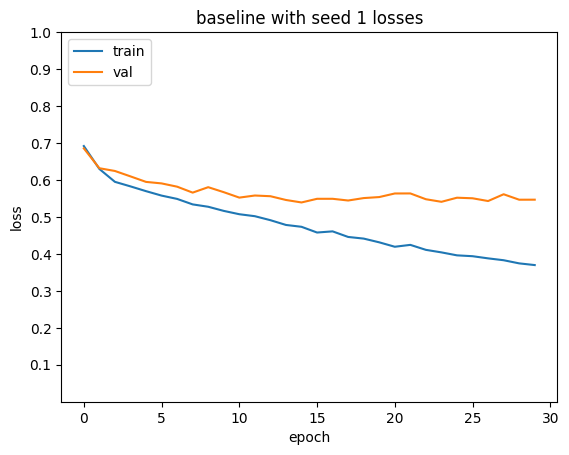

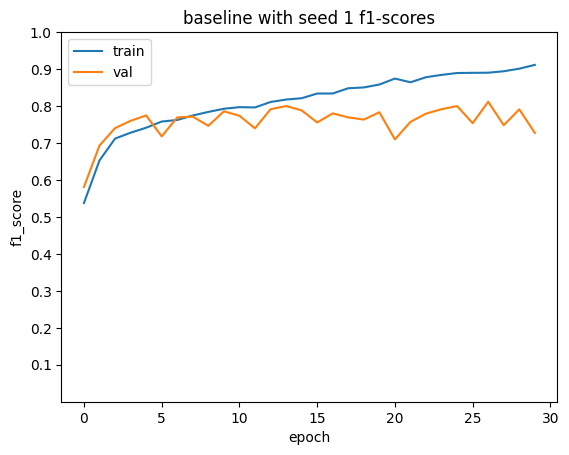

F1 score baseline with seed 1 is: 0.7886930091185409
==================================================Training model baseline with seed: 10
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step - accuracy: 0.5098 - f1_score: 0.2988 - loss: 0.6948 - val_accuracy: 0.5759 - val_f1_score: 0.0563 - val_loss: 0.6953
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.5671 - f1_score: 0.3889 - loss: 0.6860 - val_accuracy: 0.7152 - val_f1_score: 0.7239 - val_loss: 0.6407
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.6919 - f1_score: 0.6977 - loss: 0.6037 - val_accuracy: 0.7658 - val_f1_score: 0.7517 - val_loss: 0.6192
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.7291 - f1_score: 0.7117 - loss: 0.5926 - val_accuracy: 0.7595 - val_f1_score: 0.7500 - val_loss: 0.6092
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.7612 - f1_score: 0.7417 - loss: 0.5743 - val_accuracy: 0.7658 - val_f1_score: 0.7517 - val_loss: 0.5984
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step - accuracy: 0.7679 - f1_score: 0.7598 - loss: 0.5590 - val_accuracy: 0.7848 - val_f1_score: 0.7703

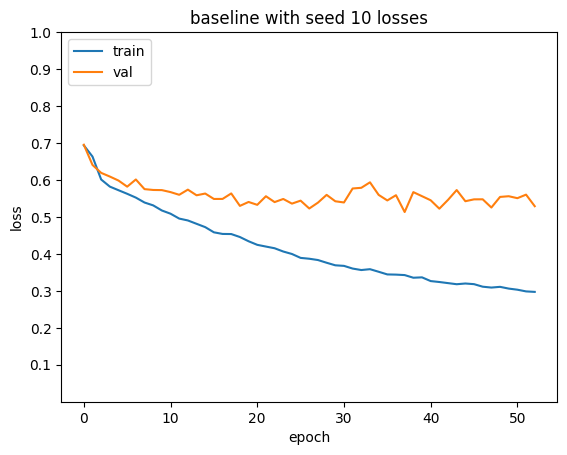

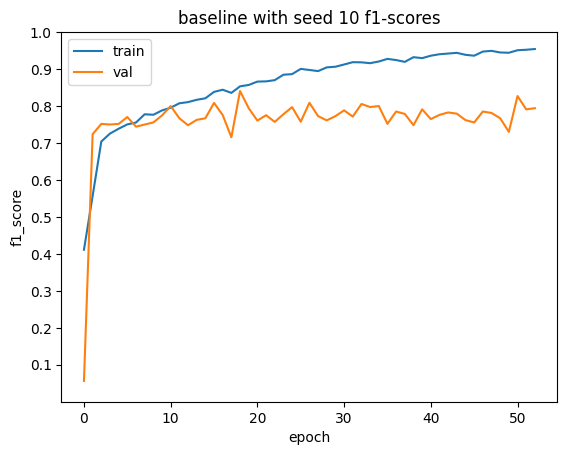

F1 score baseline with seed 10 is: 0.7848566123375285
==================================================Training model baseline with seed: 100
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.4864 - f1_score: 0.5338 - loss: 0.6892 - val_accuracy: 0.6139 - val_f1_score: 0.6772 - val_loss: 0.6452
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.6336 - f1_score: 0.6727 - loss: 0.6211 - val_accuracy: 0.7532 - val_f1_score: 0.7547 - val_loss: 0.6247
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.7054 - f1_score: 0.7153 - loss: 0.5861 - val_accuracy: 0.7722 - val_f1_score: 0.7632 - val_loss: 0.6085
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.7507 - f1_score: 0.7352 - loss: 0.5741 - val_accuracy: 0.7468 - val_f1_score: 0.7468 - val_loss: 0.6050
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.7690 - f1_score: 0.7595 - loss: 0.5581 - val_accuracy: 0.7532 - val_f1_score: 0.7547 - val_loss: 0.5894
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.7602 - f1_score: 0.7452 - loss: 0.5636 - val_accuracy: 0.7848 - val_f1_score: 0.7639

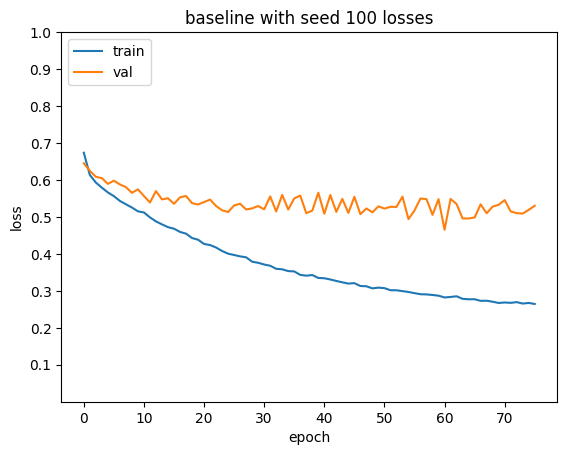

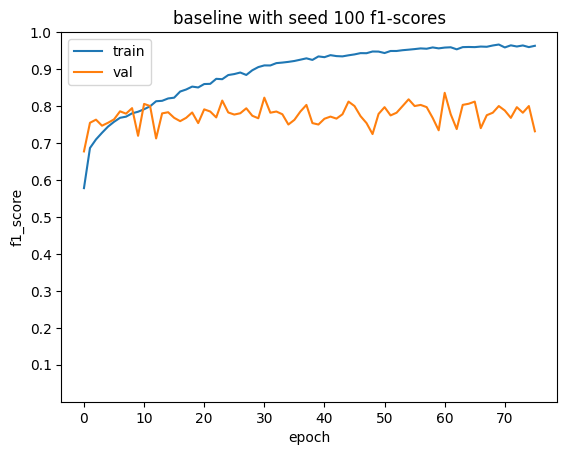

F1 score baseline with seed 100 is: 0.7987591930646288
Average Validation F1_Score is: 0.7907696048402327
Standard Deviation Validation F1_Score is: 0.005862571964698164


In [41]:
baseline_models = train_and_evaluate(baseline_model, x_train, y_train, x_val, y_val,
                    macro_f1_score_baseline, 0.0001, 32, 100, class_weights, [1,10,100])

### Model1 training

==================================================Training model model1 with seed: 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.4764 - f1_score: 0.5194 - loss: 0.6950 - val_accuracy: 0.4684 - val_f1_score: 0.5800 - val_loss: 0.6935
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.5153 - f1_score: 0.6077 - loss: 0.6653 - val_accuracy: 0.6203 - val_f1_score: 0.6739 - val_loss: 0.6412
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.6513 - f1_score: 0.6895 - loss: 0.6180 - val_accuracy: 0.7025 - val_f1_score: 0.6759 - val_loss: 0.6232
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.7073 - f1_score: 0.6935 - loss: 0.6066 - val_accuracy: 0.7342 - val_f1_score: 0.7375 - val_loss: 0.6046
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.7378 - f1_score: 0.7157 - loss: 0.5887 - val_accuracy: 0.7532 - val_f1_score: 0.6929 - val_loss: 0.6208
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.7503 - f1_score: 0.7066 - loss: 0.6002 - val_accuracy: 0.7468 - val_f1_score: 0.7436

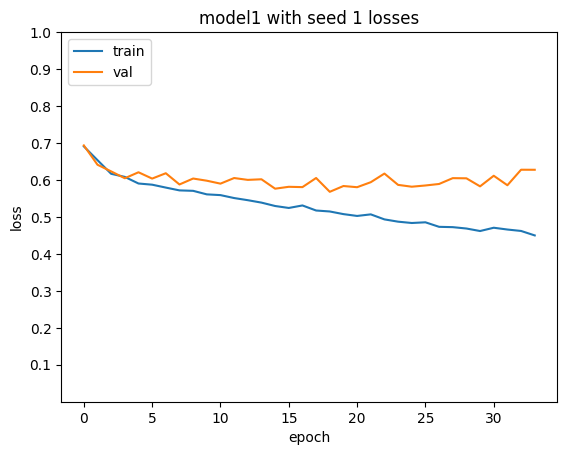

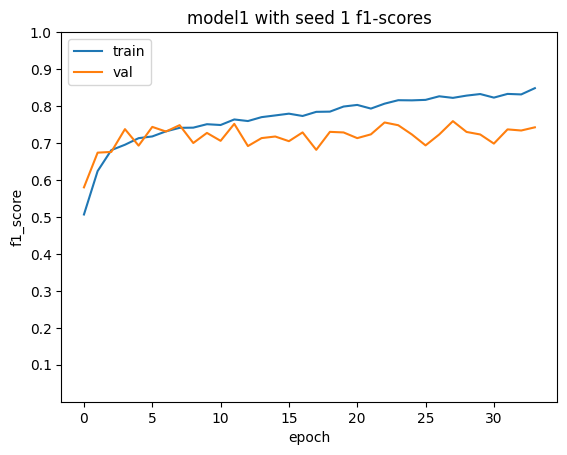

F1 score model1 with seed 1 is: 0.7718176191458634
==================================================Training model model1 with seed: 10
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.4905 - f1_score: 0.5185 - loss: 0.6924 - val_accuracy: 0.6392 - val_f1_score: 0.6545 - val_loss: 0.6774
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.5679 - f1_score: 0.6381 - loss: 0.6536 - val_accuracy: 0.6139 - val_f1_score: 0.6554 - val_loss: 0.6467
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.6670 - f1_score: 0.6792 - loss: 0.6132 - val_accuracy: 0.7342 - val_f1_score: 0.6957 - val_loss: 0.6324
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.7100 - f1_score: 0.6926 - loss: 0.6112 - val_accuracy: 0.7658 - val_f1_score: 0.7413 - val_loss: 0.6122
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.7415 - f1_score: 0.7141 - loss: 0.5977 - val_accuracy: 0.6962 - val_f1_score: 0.6800 - val_loss: 0.6207
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.7374 - f1_score: 0.7291 - loss: 0.5780 - val_accuracy: 0.7405 - val_f1_score: 0.7211

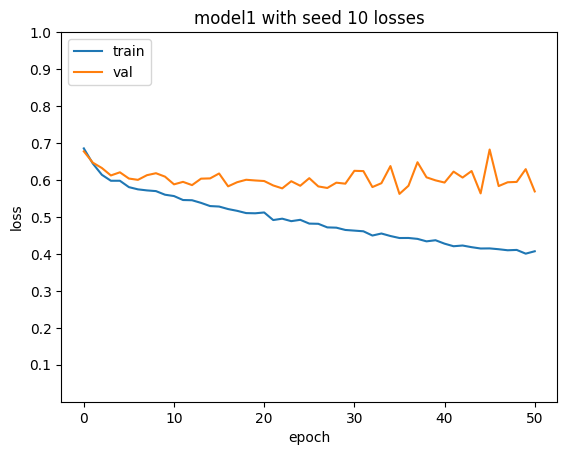

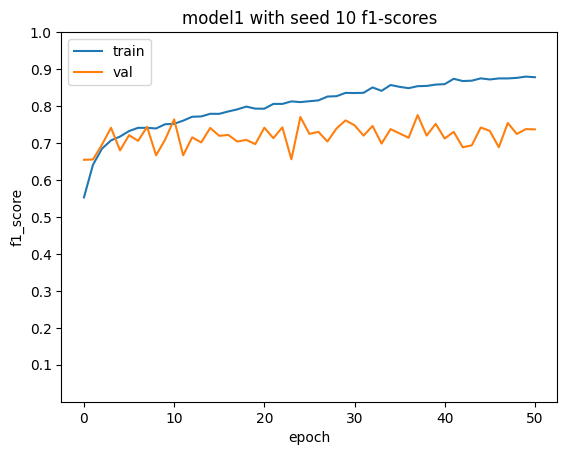

F1 score model1 with seed 10 is: 0.7718176191458634
==================================================Training model model1 with seed: 100
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.4398 - f1_score: 0.5191 - loss: 0.6983 - val_accuracy: 0.5570 - val_f1_score: 0.6111 - val_loss: 0.6877
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.5107 - f1_score: 0.5906 - loss: 0.6709 - val_accuracy: 0.6392 - val_f1_score: 0.6885 - val_loss: 0.6408
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.6616 - f1_score: 0.6854 - loss: 0.6125 - val_accuracy: 0.7215 - val_f1_score: 0.7215 - val_loss: 0.6127
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.7155 - f1_score: 0.6997 - loss: 0.5971 - val_accuracy: 0.7405 - val_f1_score: 0.7389 - val_loss: 0.6178
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.7510 - f1_score: 0.7428 - loss: 0.5802 - val_accuracy: 0.7089 - val_f1_score: 0.7013 - val_loss: 0.5972
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.7368 - f1_score: 0.7079 - loss: 0.6008 - val_accuracy: 0.7405 - val_f1_score: 0.6917

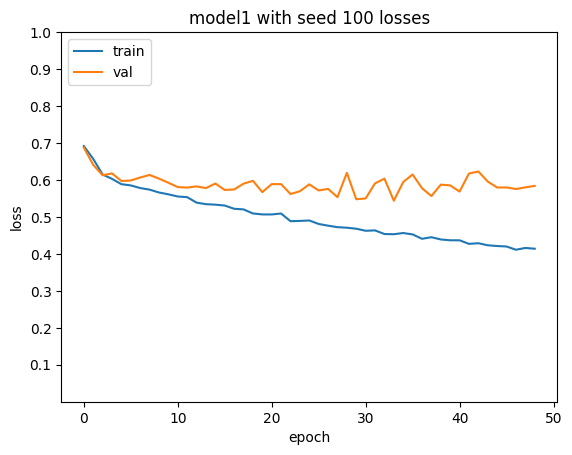

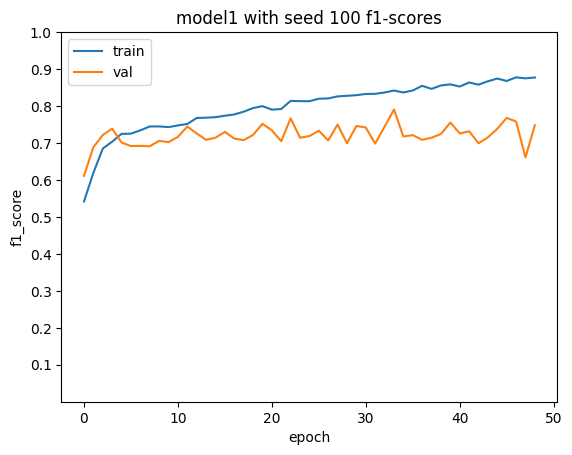

F1 score model1 with seed 100 is: 0.7658102766798418
Average Validation F1_Score is: 0.7698151716571896
Standard Deviation Validation F1_Score is: 0.002831888396422544


In [45]:
model1_models = train_and_evaluate(model1, x_train, y_train, x_val, y_val,
                   macro_f1_score_model1, 0.00005, 32, 100, class_weights, [1,10,100])

### Final Evaluation

Confronting the Validation mean scores of baseline and model1 we can see that baseline is the better model, so we'll focus on it for the final evaluation.

In [71]:
def majority_voting_evaluation(model, model_params, x_val, y_val, validation_set):
    """
    Function to perform Majority voting using all variations of the same model trained with different seeds: 
    for each seed the corresponding istance of the model is tested, obtaining its resulting labels, each model 
    then casts a vote to determine the final labels. Using these, the model's final F1 score is computed, as
    well as visualizing a confusion matrix.
    >model: base model to evaluate
    >model_params: dictionary in the form {'seed':(F1 score, weight_file_name)} allows the retrieval of each set of weights corresponding to a seed
    >x_val: input data for evaluation
    >y_val: output data for evauation
    >validation_set: original validation set in order to retrieve tweets to visualize and help in error analysis.
    """
  votes = []
  for s in model_params.keys():
    model.load_weights(model_params[s][1])
    y_pred = np.round(model.predict(x_val))
    votes.append(y_pred)

  final_votes = []
  for i in range(len(votes[0])):
    final_votes.append(multimode([tuple(votes[j][i].flatten()) for j in range(len(model_params))])[0][0])


  F1_score = metrics.f1_score(y_val, y_pred, average='macro')
  print(f"F1 score {model.name} with majority voting is: {F1_score}")

  confusion_matrix = metrics.confusion_matrix(y_val, final_votes)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()
  res = pd.DataFrame({'input':validation_set['tweet'].tolist(),
                       'prediction':final_votes,
                       'true':y_val.flatten()})
  pd.set_option('display.max_colwidth', None)
  display(res.head(20))

#### Evaluate Baseline on Validation set

2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
F1 score baseline with majority voting is: 0.7978956055291933


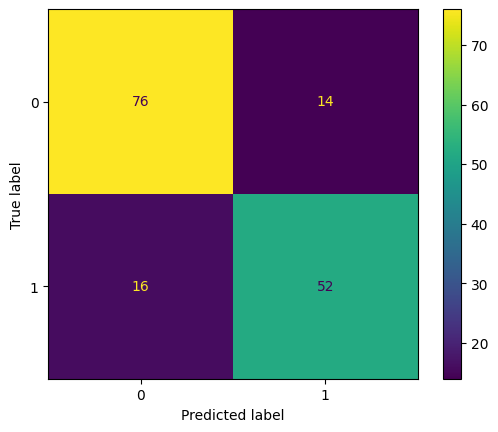

,input,prediction,true
0,you should smile more love just pretend you be a tory open a food bank we be only live through the bad in living memory so it be all a bit of a giggle cheer up darling it might never happen,0.0,0
1,she be right but the push be all in the opposite direction convert female only space to mixed sex and deny woman and girl the privacy and safety of male free area male behaviour be the problem not female behaviour until this change we must preserve boundary,1.0,1
2,some man move my suitcase in the overhead luggage storage on a train to what he think be a well position why and now completely out of my reach for when I have to rush off the train in a couple of stop woman can not arrange their own luggage apparently,1.0,1
3,lol gamergate the go to boogieman maybe if the actual concern bring up during gamergate be listen to and not ridicule then all the people who be so scared of it would not have be meme on so hard,0.0,0
4,to I this have the same negativity as gamergate where people want to act like it be about journalistic ethic but it be really an excuse to attack creator they do not like,1.0,0
5,yeah it be a core meme in the pre gamergate era that build the culture among online nerd to go into it,0.0,0
6,show off the man spend his money help the economy I only hope the couple who win be harass as much to pay tax or be win the lottery more acceptable for the envious than people actually earn their wealth,0.0,0
7,getting twitter harass for pro choice,0.0,1
8,I be hide in cat twitter mental health be really bad see a psychologist on friday I go to suicidal thought after be bully and harass by someone who be now no long a friend of mine or hubby,0.0,0
9,they so remind I of mgtow man go their own way in we full of man who hate woman obessively talk about woman just go your own way we do not fcke care and the envy pic of creepy man not have lunch but stare into their camera alone or from a woman s loo,1.0,1


In [72]:
majority_voting_evaluation(baseline_model, baseline_models, x_val, y_val, validation)

#### Evaluate Baseline on Test set

The best model (baseline) is evaluated on the test set as an additional evaluation metric and to further confront it with the Transformer.

3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
F1 score baseline with majority voting is: 0.7599367994864958


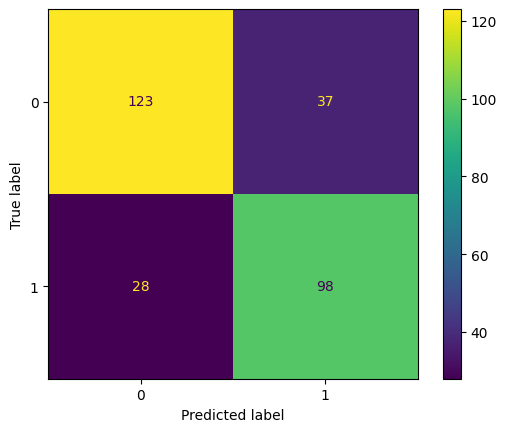

,input,prediction,true
0,day at the pool on a beautiful sunday in ny too bad few dare to go in due to the frigid water temp we last min and figure we prove our point,0.0,0
1,I like your outfit too except when I dress up as a frigid bitch I try not to look so constipate be my new how be you,1.0,1
2,same though the angst just come and go lonely xie lian will always break my frigid heart,1.0,0
3,fuck that cunt try to vote she out multiple time,1.0,1
4,you got to say some shit like I will fuck that cunt dumb until you can not remember anything but my name you stupid slut,1.0,1
5,mmm fuck that cunt be hungry for this dick be not it such a shame that you can lie all you want about not want this but your body never can he say in she ear before he start kiss down her neck make sure to leave plenty of love mark on her pale skin,1.0,1
6,suika get gangbange to death,0.0,1
7,I mean I do but would not it be fun to get gangbange together,0.0,0
8,maybe something involve she getting gangbange,0.0,1
9,sex as in gender harassment be what they be infer,1.0,0


In [74]:
majority_voting_evaluation(baseline_model, baseline_models, x_test, y_test, test)

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Model Definition

In [51]:
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
#MODEL = "Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two"

### Loading Data

In [52]:
#Data is converted into the appropriate data structure from preprocessing pipeline after step 2 (without embedding)
training_data = Dataset.from_pandas(training)
validation_data = Dataset.from_pandas(validation)
test_data = Dataset.from_pandas(test)

### Transformer data preprocessing

In [53]:
#Loading from huggingface the tokenizer for the desired model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [54]:
def preprocess_text(texts):
    """
    Function to preprocess text, the loaded tokenizer is applied allowing truncation of large sentences
    in case the surpass a certain specified length.
    >text: texts to be preprocessed
    """
    return tokenizer(texts['tweet'], truncation=True)


In [55]:
#Preprocessing is performed on the training, validation and test dataset
training_data = training_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

#Visualize data after preprocessing to obeserve the results
print(training_data[0])

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

{'lang': 'en', 'tweet': 'write a uni essay in my local pub with a coffee random old man keep ask I drunk question when I be try to concentrate end with good luck but you will just end up get married and not use it anyway be alive and well', 'hard_label_task1': 1, 'id_EXIST': '200002', 'input_ids': [0, 29631, 10, 542, 118, 14700, 11, 127, 400, 8881, 19, 10, 3895, 9624, 793, 313, 489, 1394, 38, 10789, 864, 77, 38, 28, 860, 7, 14410, 253, 19, 205, 6620, 53, 47, 40, 95, 253, 62, 120, 2997, 8, 45, 304, 24, 6992, 28, 4299, 8, 157, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [56]:
#Creating the data collator which will be used to pass data during training, it
#is configured to add padding to shorter inputs.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [57]:
#Dataset label column is renamed to match the one expected by the model
training_data = training_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

### Loading the Model and initializing metrics

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL,
                                                           num_labels=2,
                                                           id2label={0: 'NEG', 1: 'POS'},
                                                           label2id={'NEG': 0, 'POS': 1})
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
print(model)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [59]:
def compute_metrics(output_info):
    """
    Function to compute metrics during training, starting from the outputs predicted labels are
    computed and compared with the true labels, calculating the f1 macro score.
    >output_info: tuple containing the predictions and the labels
    """
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)  # For cardiffnlp/twitter-roberta-base-hate
    #predictions = np.argmax(predictions[0], axis=-1) #For Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two

    if np.ndim(predictions) == 0:
        predictions = np.expand_dims(predictions, axis=0)
    if np.ndim(labels) == 0:
        labels = np.expand_dims(labels, axis=0)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return {**f1, **acc}

### Model Fine-tuning

The Huggingface transformer model was fine-tuned trying the most to keep the original hyperparameters, experimenting with linear and cosine annealing for the scheduling of the learning rate (which was lowered) and attempting to run with more epochs, while we noticed some slight improvements with LR scheduling, adding more epochs was useless as every model seemed to reach its best performances before the 10th epoch.

In [66]:
#Defining the training hyperparamters
training_args = TrainingArguments(
    output_dir="/kaggle/working",
    learning_rate=2e-6,
    lr_scheduler_type='linear',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)
#Inserting input data
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [67]:
#Training Loop
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.359906,0.874262,0.879747
2,No log,0.362649,0.880544,0.886076
3,0.271200,0.370533,0.887497,0.892405
4,0.271200,0.403302,0.873541,0.879747
5,0.271200,0.383754,0.874262,0.879747
6,0.242500,0.423767,0.873541,0.879747
7,0.242500,0.421778,0.873541,0.879747
8,0.242500,0.434897,0.866486,0.873418
9,0.203800,0.421606,0.873541,0.879747
10,0.203800,0.427613,0.873541,0.879747


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1800, training_loss=0.23040482415093316, metrics={'train_runtime': 455.1696, 'train_samples_per_second': 63.053, 'train_steps_per_second': 3.955, 'total_flos': 854615541136080.0, 'train_loss': 0.23040482415093316, 'epoch': 10.0})

### Model Evaluation

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'f1': 0.8515130537974683, 'accuracy': 0.8531468531468531}


,lang,tweet,label,id_EXIST,input_ids,attention_mask,prediction
0,en,day at the pool on a beautiful sunday in ny too bad few dare to go in due to the frigid water temp we last min and figure we prove our point,0,400178,"[0, 1208, 23, 5, 3716, 15, 10, 2721, 28087, 857, 11, 295, 219, 350, 1099, 367, 19046, 7, 213, 11, 528, 7, 5, 25805, 808, 514, 32196, 52, 94, 5251, 8, 1955, 52, 3364, 84, 477, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
1,en,I like your outfit too except when I dress up as a frigid bitch I try not to look so constipate be my new how be you,1,400179,"[0, 100, 101, 110, 7490, 350, 4682, 77, 38, 3588, 62, 25, 10, 25805, 808, 32594, 38, 860, 45, 7, 356, 98, 10759, 1588, 877, 28, 127, 92, 141, 28, 47, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
2,en,same though the angst just come and go lonely xie lian will always break my frigid heart,0,400180,"[0, 41690, 600, 5, 33010, 95, 283, 8, 213, 20100, 3023, 324, 784, 811, 40, 460, 1108, 127, 25805, 808, 1144, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
3,en,fuck that cunt try to vote she out multiple time,1,400181,"[0, 44412, 14, 48391, 860, 7, 900, 79, 66, 1533, 86, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
4,en,you got to say some shit like I will fuck that cunt dumb until you can not remember anything but my name you stupid slut,1,400182,"[0, 6968, 300, 7, 224, 103, 15328, 101, 38, 40, 26536, 14, 48391, 16881, 454, 47, 64, 45, 2145, 932, 53, 127, 766, 47, 12103, 44046, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
5,en,mmm fuck that cunt be hungry for this dick be not it such a shame that you can lie all you want about not want this but your body never can he say in she ear before he start kiss down her neck make sure to leave plenty of love mark on her pale skin,1,400183,"[0, 41311, 26536, 14, 48391, 28, 11130, 13, 42, 38594, 28, 45, 24, 215, 10, 9208, 14, 47, 64, 6105, 70, 47, 236, 59, 45, 236, 42, 53, 110, 809, 393, 64, 37, 224, 11, 79, 5567, 137, 37, 386, 13301, 159, 69, 5397, 146, 686, 7, 989, 2710, 9, 657, 2458, 15, 69, 18100, 3024, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
6,en,suika get gangbange to death,1,400184,"[0, 9228, 4151, 120, 5188, 428, 10987, 7, 744, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
7,en,I mean I do but would not it be fun to get gangbange together,0,400185,"[0, 100, 1266, 38, 109, 53, 74, 45, 24, 28, 1531, 7, 120, 5188, 428, 10987, 561, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
8,en,maybe something involve she getting gangbange,1,400186,"[0, 31501, 402, 6877, 79, 562, 5188, 428, 10987, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
9,en,sex as in gender harassment be what they be infer,0,400187,"[0, 8821, 25, 11, 3959, 4331, 28, 99, 51, 28, 40182, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1


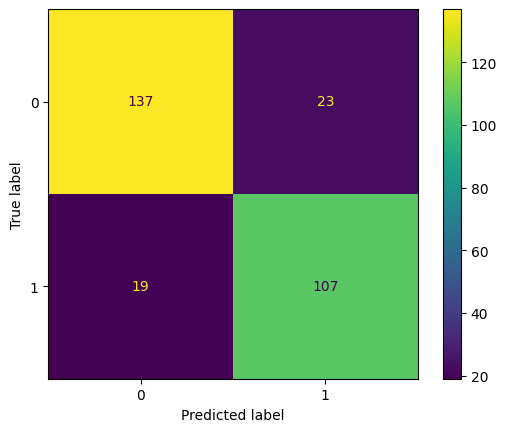

In [70]:
#Evaluate the model on the test set
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

test_data=test_data.add_column('prediction', np.argmax(test_predictions, axis=-1))
display(test_data.to_pandas().head(20))

confusion_matrix = metrics.confusion_matrix(test_labels, np.argmax(test_predictions, axis=-1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

# [Task 7 - 0.5 points] Error Analysis

#### Considerations on models
Observing the outputs of the three different model we can immediately conclude that the Transformer model is the best performing one, easily outperforming the two LSTM custom models. This is coherent with current NLP findings where Transformers are considered one of the most versatile model for tasks such as this.
Confronting the two LSTM models we can see, that, despite its larger complexity, Model1 underprformed with respect to Baseline, from what we can observe Model1 is simply a bit more prone on failing on instances on which Baseline already struggles. Our main guess is that the additional complexity only leads to further confusion for the model.

#### The role of OOVs
Despite the successes of the Transformer, there is still a margin for improvements as there are some classification mistake commonly found in all models, our main guess is that the source of these errors is related to the initial encoding, as from the beginning we knew that there was a high percentage of OOVs (almost 10%) which definitely play a role in the capability of the model to understand the sentiment of the sentences.
Specifically, we observed that the models perform worse on sentences that contain OOVs, expecially if those words carry much of the sexist sentiment, among these we identified some unusual or infromal word such as slurs, slang which may not be present in the embedding, even in a twitter oriented one. 

#### Incorrect lemmatization

Relate to the aforementioned topic we discovered that incorrect lemmatization plays an active role in the undesired creation of OOVs as some words are wrongly lemmatized into non-existent forms, making their association with an existing encoding impossible. An example of this phenomenon was discovered by analysing three sentences containing the expression 'gangbanged' two of which where incorrectly classified by the LSTMs and one by the Transformer: in this case the expression was lemmatized as a regular verb with 'gangbange' which is not an existing word; incidentally, both 'gangbang' and 'gangbanged' were both contained in the GloVe embedding, but the lemmatized form was clearly not, which led to its classification as an OOV word. The higher performance registered by the transformer can be explained by its larger flexibility at learning new word embeddings in cases such as this.

#### Class imbalance
Observing the confusion matrices we can see a very narrow prevalence of tweets wrongly classfied as sexist, in contrast with the original imbalance; this may be also a consequence of the usage of class weights which succesfully countered imbalance but brought a bit too much focus on the underrepresented class. However, there is also the chance that this result is a product of a reduced number of instances use to perform the tests.

#### Sexism as a topic
Another thing we noticed is that all models seem to struggle a little more on detecting sexism whent it's being treated as discorse topic instead of being the main focus of the tweet, especially if the tweets present the argument in a neutral without using strong expressions. We can suppose that the models learned to rely on strong sentiments to detect sexism, probably because of an imbalance between outright sexist tweets and others which where just discussing on the topic.

#### Long sentences
Lastly, we observed that the LSTMs tend to perform worse than the Transformer on longer sentences, this can be easily explained by the Transofrmer's superior capabilities of exploiting wide contextual information.

#### Addressing the issues
Regarding all of the issues mentioned above we hypothesized a few solutions to address them:
* In order to reduce the number of OOVs it is always the better option to utilize embeddings closely releted to the task at hand, in our case, the usage of a twitter based embedding reduced the percentage of OOVs of 5%.
* As incorrect lemmatization can occur, the lemmatization process should be carried out using instruments specifically designed for the task at hand in order to avoid converting potentially informative words in useless tokens.
* Another possibility to reduce the effect of OOVs can be the usage of a more refined embedding assignment, potentially based on edit distance in order to already locate a word in a more familiar cluster instead of a random one. In our case we attempted this approach but it was too computationally prohibitive.

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Experiments with another Transformer Architecture

Other than with cardiffnlp/twitter-roberta-base-hate Transformer model, we run a few experiments using another pre-trained model, namely 
**Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two**, a BERT-derived model initially trained to identify three types of tweets: Normal, Abusive and Hateful, this specific version is trained to unify the last two categories in order to have two labels. 
However, the model still wasn't capable of achieving the same performances of roBERTa, stopping at 0.84 F1 test score. The reason for this result can be probably found in its initial training based on three labels instead of two.

### Classify Spanish Tweets

Finally, we made some attempts at classifying Spanish tweets with baseline LSTM model using the same hyperparameters.
The preprocessing pipeline was mostly the same as the one used for English tweets with a particular attention on removing accents (more present in Spanish words) and without removing contractions (which are absent). 
As we noticed that the GloVe twitter contains multilingual embeddings we tried to use the same embedding model even for these tokens but unfortunately it was not as rich as the English counterpart, leading to a 20% of OOVs.
There is also the chance of some words being present in other languages' vocabularies with different meanings which are wrongly assigned to the less represented Spanish words.
As a consequence, the performances were not great, as the model struggles to extract meaning from the tweets.
Some possible improvements could be achieved by using a Spanish oriented embedding or by explicitly fine-tuning the model.

In [161]:
#Loading the dataset from the start (Spanish test set is empty)
training_es = load_data("training")
validation_es = load_data("validation")

In [162]:
#Recreate the hard label
create_hl1(training_es)
create_hl1(validation_es)

6920it [00:05, 1332.45it/s]
726it [00:00, 4012.48it/s]


In [163]:
#Remove english rows and useless columns
training_es = remove_cols(training_es, 'es')
training_es = hot_enc(training_es)
validation_es = remove_cols(validation_es, 'es')
validation_es = hot_enc(validation_es)

In [164]:
#Loading the spacy Spanish model for lemmatization
esp_model = spacy.load("es_core_news_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [165]:
#Cleaning the Training and Validation sets
training_es=clean_dataframe(training_es, False, True, 'es')
validation_es=clean_dataframe(validation_es, False, True, 'es')

3194it [00:25, 124.70it/s]
490it [00:03, 127.38it/s]


In [80]:
#Retrieving tokens
tokens_es, oov_es, oov_percentage_es = retrieve_tokens(training_es, emb_model)
print(f"Total OOV in Spanish terms: {len(oov_es)} ({oov_percentage_es:.2f}%)")

100%|██████████| 3194/3194 [00:00<00:00, 237469.55it/s]


Total OOV in Spanish terms: 2319 (20.63%)


In [81]:
#Building the Spanish embedding
wrd_to_idx_es, emb_matrix_es = build_vocabulary_and_embedding(tokens_es, emb_model, emb_dim)
print(f"Embedding matrix shape: {emb_matrix_es.shape}")

Embedding matrix shape: (11244, 200)


In [86]:
#Defininf the metrics and class weights
macro_f1_score_es = tf.keras.metrics.F1Score(average="macro", threshold=0.5)
lr_scheduler_es = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=1000,decay_rate=0.95,staircase=True)

x_train_es, y_train_es = prepare_data(training_es, wrd_to_idx_es)
x_val_es, y_val_es = prepare_data(validation_es, wrd_to_idx_es)

class_weights_es = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_es),
    y=y_train_es.flatten()
)
class_weights_es = {i: class_weights_es[i] for i in range(len(class_weights_es))}
print(class_weights_es)

100%|██████████| 490/490 [00:00<00:00, 155028.21it/s]

{0: 0.9773561811505508, 1: 1.0237179487179486}


In [88]:
#Re-initializing the Baseline Model
model_es = Sequential(name='baseline spanish')
model_es.add(Input((None,), name="Input"))
model_es.add(Embedding(input_dim=len(wrd_to_idx_es),
                                      output_dim=emb_dim,
                                      weights=[emb_matrix_es],
                                      mask_zero=True,
                                      trainable = True,
                                      name='embedding'))
model_es.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)))
model_es.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_es.add(GlobalMaxPooling1D())

model_es.compile(optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler_es, global_clipnorm=10), #Previous LR = 0.001
                  loss='binary_crossentropy',
                  metrics=[macro_f1_score_es, 'accuracy'])

model_es.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_5' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "baseline spanish"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 200)           │       2,248,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 512)           │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, None, 1)             │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 1)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,185,249 (12.15 MB)

 Trainable params: 3,185,249 (12.15 MB)

 Non-trainable params: 0 (0.00 B)

==================================================Training model baseline spanish with seed: 1
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.5521 - f1_score: 0.4265 - loss: 0.6929 - val_accuracy: 0.5000 - val_f1_score: 0.5488 - val_loss: 0.6922
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.6606 - f1_score: 0.6027 - loss: 0.6606 - val_accuracy: 0.4939 - val_f1_score: 0.2051 - val_loss: 0.6924
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.7098 - f1_score: 0.6458 - loss: 0.6417 - val_accuracy: 0.4673 - val_f1_score: 0.1386 - val_loss: 0.6937
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.7233 - f1_score: 0.6441 - loss: 0.6462 - val_accuracy: 0.5082 - val_f1_score: 0.3504 - val_loss: 0.6942
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.7316 - f1_score: 0.6431 - loss: 0.6354 - val_accuracy: 0.4571 - val_f1_score: 0.0567 - val_loss: 0.6975
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 26

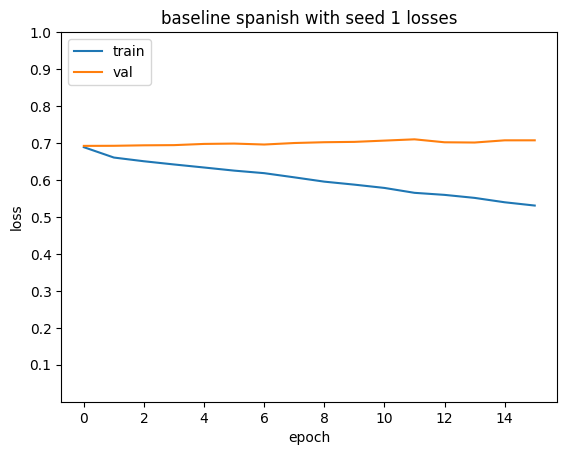

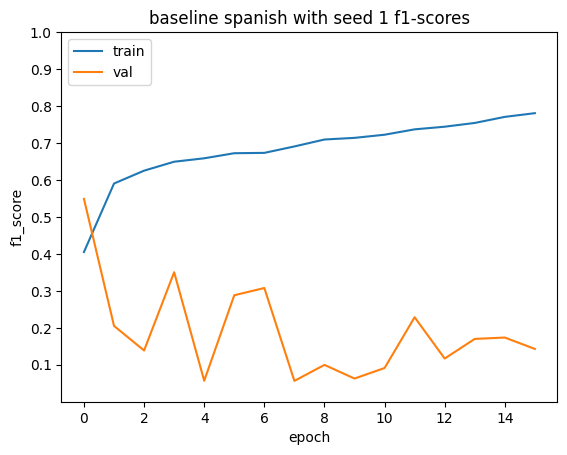

F1 score baseline spanish with seed 1 is: 0.4798564424000405
==================================================Training model baseline spanish with seed: 10
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_5' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.5482 - f1_score: 0.3464 - loss: 0.6941 - val_accuracy: 0.4878 - val_f1_score: 0.4010 - val_loss: 0.6935
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.6520 - f1_score: 0.6192 - loss: 0.6716 - val_accuracy: 0.4673 - val_f1_score: 0.0906 - val_loss: 0.6937
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.7222 - f1_score: 0.6158 - loss: 0.6509 - val_accuracy: 0.4898 - val_f1_score: 0.3017 - val_loss: 0.6915
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.7228 - f1_score: 0.6343 - loss: 0.6467 - val_accuracy: 0.4796 - val_f1_score: 0.3855 - val_loss: 0.6926
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.7582 - f1_score: 0.6763 - loss: 0.6342 - val_accuracy: 0.5061 - val_f1_score: 0.3046 - val_loss: 0.6928
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.7365 - f1_score: 0.6823 - loss: 0.6254 - val_accuracy: 0.4531 - val_f1_score: 0.2164

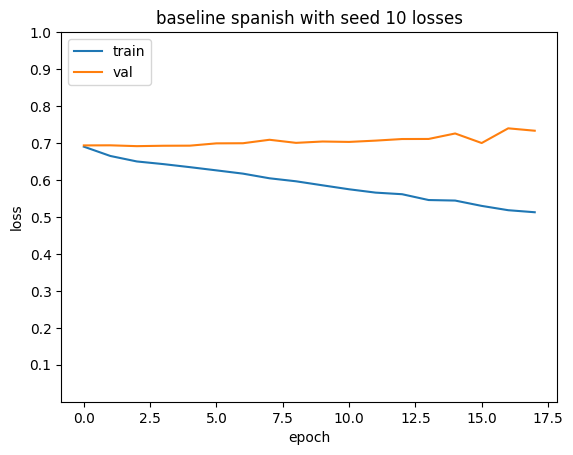

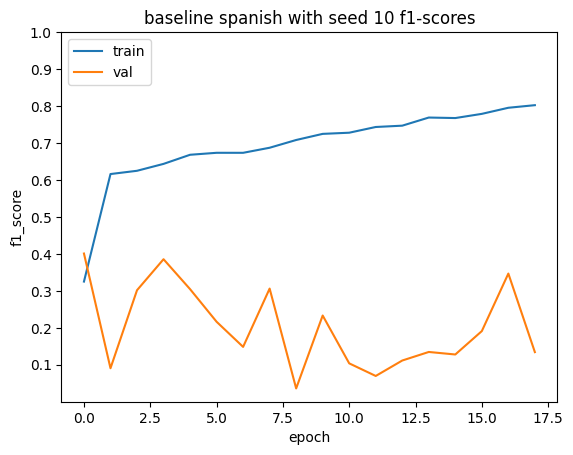

F1 score baseline spanish with seed 10 is: 0.4542743717329214
==================================================Training model baseline spanish with seed: 100
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_5' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.5496 - f1_score: 0.4445 - loss: 0.6937 - val_accuracy: 0.4755 - val_f1_score: 0.4951 - val_loss: 0.6936
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.6708 - f1_score: 0.6012 - loss: 0.6610 - val_accuracy: 0.4837 - val_f1_score: 0.4130 - val_loss: 0.6935
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.7133 - f1_score: 0.6568 - loss: 0.6431 - val_accuracy: 0.4673 - val_f1_score: 0.0440 - val_loss: 0.6942
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.7462 - f1_score: 0.6697 - loss: 0.6434 - val_accuracy: 0.4735 - val_f1_score: 0.0652 - val_loss: 0.6946
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.7381 - f1_score: 0.6690 - loss: 0.6355 - val_accuracy: 0.4776 - val_f1_score: 0.3568 - val_loss: 0.6945
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.7374 - f1_score: 0.6733 - loss: 0.6258 - val_accuracy: 0.4469 - val_f1_score: 0.0997

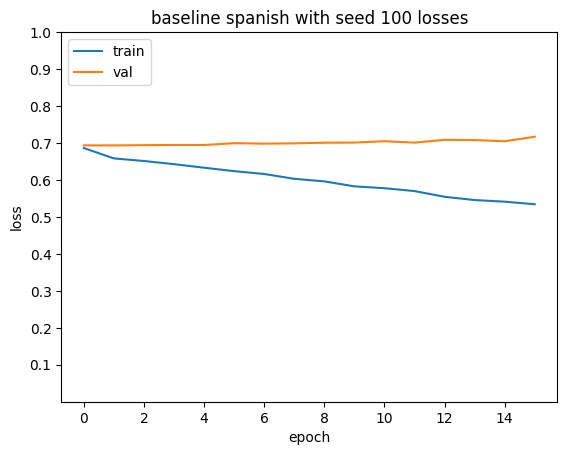

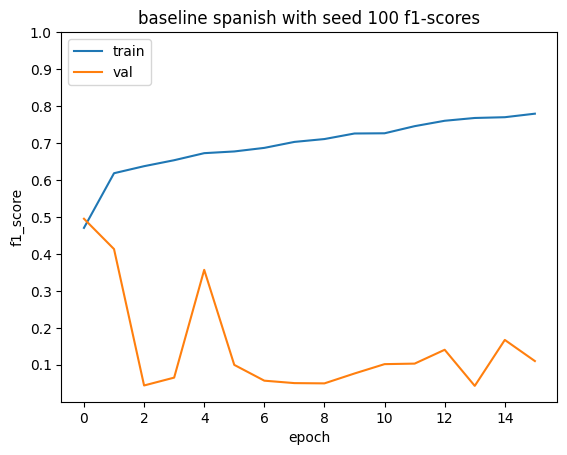

F1 score baseline spanish with seed 100 is: 0.4681117549807117
Average Validation F1_Score is: 0.46741418970455784
Standard Deviation Validation F1_Score is: 0.010455478082174292


In [89]:
#Training and evaluating the Spanish Model
models_es = train_and_evaluate(model_es, x_train_es, y_train_es, x_val_es, y_val_es,
                    macro_f1_score_es, 0.0001, 32, 100, class_weights_es, [1,10,100])

 3/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_5' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
F1 score baseline spanish with majority voting is: 0.4914788001550445


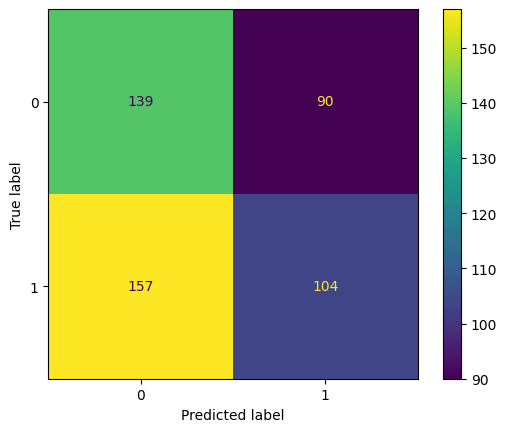

,input,prediction,true
0,no yo acordar de el detalle de gamergate pero él estar en el ojo del huracar recibir acoso de hombre indignado y su medio frikis y creer que tambien acosar a brianna wu q ser transfemenino seguramente tener ese que ver y querer cerrar fila,1.0,1
1,él decir cada poco dia y él repetir todo este él poder evitar si él haber parar el gamergate a tiempo,0.0,0
2,also mientras él deciar ese él senalar y deciar que como el era del staff él ir a ban de ese evento intel behavior much este cabron haber sexually harassed women and girls en el community y cuando ser confrontar él negativir y mentir ahora salio con este haber should be banned,0.0,1
3,and all peoplir killed attacked harassed by cam mapuche resistance siches is a real piecir of work ministra del interior y muerte de trabajador mapuche no habiar ver uno atentado directo hacia civil via,1.0,0
4,on this i m thinking of journalists medio workers in mexico killed imprisoned or harassed for their work pensar en todxs lxs periodistxs assasinadxs incarceradxs o hostigadxs por su oficio,1.0,0
5,el izquierda tener culpa en su silencio cuando él interesar de valorar mujer violado de y de depender de nacionalidad de y como en el asunto inmigracion su discurso ser el unico de riqueza cultural pues callar como puta,1.0,1
6,uyyy a q huele apesta a xenofobia quien no dar uno ser el derecha y el como tu negar uno realidad como el y el blanquear con otro nombre precisamente de san fermin ser de el cuerpo de seguridad del estado que yo este contar,0.0,1
7,con león y mas en el grada,0.0,0
8,yo gustario saber que futbolista condenado por abuso seguir en nomina y el verdad el caso de amber no él poder comparar con nada porque ser uno mujer que utilacer el metoo para destruir el carrera de su ex uno actor mucho querido,0.0,1
9,el hombre perfecto para este mujer sera uno lindo gato a quien cuidar cuando par el ano el mas exigente que ir preparar su pasaporte a gatolandia mgtow siempre ganar,1.0,1


In [90]:
#Visualizing the results
majority_voting_evaluation(model_es, models_es, x_val_es, y_val_es, validation_es)





# The End